In [2]:
import clip
import os
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

HOME = "/Users/james/src/machine-learning/Mug-Detector-6"
TRAIN_DIR = HOME + "/train"

test_images = os.listdir(TRAIN_DIR)

print(len(test_images))

219


In [63]:
import importlib
import clip_helpers

importlib.reload(clip_helpers)

index, reference = clip_helpers.create_index(TRAIN_DIR)

In [64]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# get all embeddings from index
embeddings = []

for i in range(len(reference)):
    image_features = index.reconstruct(i)
    embeddings.append(image_features)

embeddings = np.array(embeddings)

# fit nearest neighbors
cluster = NearestNeighbors(n_neighbors=10, metric="cosine")

cluster.fit(embeddings, np.array([i for i in range(len(embeddings))]))

NearestNeighbors(metric='cosine', n_neighbors=10)

/var/folders/z1/8yh0v9r16_d470tvttlwhls80000gn/T/ipykernel_77977/3529111269.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow")


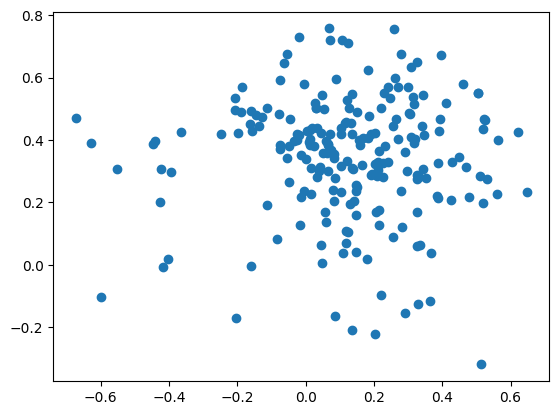

In [65]:
import matplotlib.pyplot as plt

# create scatter plot with embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow")
plt.show()

In [66]:
# avg dist to nearest neighbor
avg_dist = []

for i in range(len(embeddings)):
    dist, _ = cluster.kneighbors([embeddings[i]])
    avg_dist.append(np.mean(dist))

print(np.mean(avg_dist))

0.12669887


In [30]:
import csv
from PIL import Image
import pandas as pd

files = []

# open image files
file = Image.open(os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0]))

image_height = file.size[0]
image_width = file.size[1]

for file in os.listdir(TRAIN_DIR):
    if file.endswith(".jpg"):
        # remove extension
        file = file.replace(".jpg", "")

        labels = TRAIN_DIR + "/labels/" + file + ".txt"

        with open(labels, "r") as f:
            data = csv.reader(f, delimiter=" ")

            for row in data:
                # get bounding box
                cx = float(row[1]) * image_width
                cy = float(row[2]) * image_height
                w = float(row[3]) * image_width
                h = float(row[4]) * image_height

                # get top left corner
                x0 = cx - w / 2
                y0 = cy - h / 2
                x1 = cx + w / 2
                y1 = cy + h / 2

                files.append([x0, y0, x1, y1])

files = pd.DataFrame(files, columns=["x0", "y0", "x1", "y1"])

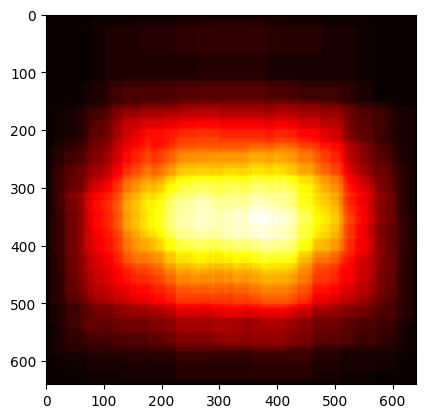

In [37]:
# generate heatmap from bbox coordinates
import numpy as np
import matplotlib.pyplot as plt

boxes = []

# create box w/ height and width
for i in range(len(files)):
    box = np.zeros((image_height, image_width))

    x0 = int(files.iloc[i]["x0"])
    y0 = int(files.iloc[i]["y0"])
    x1 = int(files.iloc[i]["x1"])
    y1 = int(files.iloc[i]["y1"])

    box[y0:y1, x0:x1] = 1

    boxes.append(box)

# sum all boxes
heatmap = np.sum(boxes, axis=0)

# plot heatmap
extent = [0, image_width, image_height, 0]

plt.imshow(heatmap, extent=extent, cmap="hot")
plt.show()